#  🚢 Ship Detection: Image Visualizations and EDA

<img src= "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR-Yxy_PxDspM7V39A-jp2dBv29geaV4OiDxg&usqp=CAU" alt ="Ships" style='width: 400px;'>

The goal of this challange is to detect and mask ships from satellite images. There are both trainig and test data available with masks on the ships encoded with a run-lenght encoding style, as we will se later. The main difficult is due to the fact that the dataset is very big and unbalanced in a sense of presence of ships in the images. Furthermore the images are from satellities and the ships rapresent only a small section over the total if we consider the pixels. We will follow a summary as follow:

<a id="introduction"></a>
## Segmentation in Image Processing

In image processing and computer vision image segmentation is a very important and useful task. It consists in partitioning the image into multiple segments, or sets of pixels that belong to a patrticular class. In particular the task is to assing a particular label to every pixel in the image based on some shared characteristics, the results produces a mask, a set of segments that cover the entire or part of the image. The applications of this kind of machine learning task are huge for example in the medical imaging of face recogniction.

There are two main segmentation approches:
* **Semantic Segmentation**: all pixels belonging to a particular class are considered together as one mask.
* **Instance Segmentation**: the pixels are divided into different objects, even if belong to the same class.

In our case the problem is a Instance Segmentation one, in particular we have to match every ship in the images and find the pixels belonging to that particular class. 






# Table of contents

Intro
[Segmentation in Image Processing](#introduction)

1.[Loading libraries and functions](#section-one)
 - [Libraries](#subsection-one-1)
 - [Functions](#subsection-two-1)
 
2.[Exploratory Data Analysis (EDA)](#section-two)
 - [Statistics about data](#subsection-one-2)
 - [Images Visualizations](#subsection-two-2)
 - [Data Sampling](#subsection-three-2) 


<a id="section-one"></a>
## Loading libraries and functions

In this section we will load the libraries and the function that will be used in the notebook.

<a id="subsection-one-1"></a>
## Libraries
Importing all the libraries used in the notebook 

In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt

import seaborn as sns
import os #to load the data
import random
import PIL #manage images 

from skimage.io import imread, imshow, concatenate_images
from skimage import io, transform
from skimage.measure import label, regionprops

<a id="subsection-one-2"></a>
## Functions

In this section we will report the function we used for different purpose, this will help us in the computation and in the readness of the notebook.



In [3]:
#apply a particluar mask over the image 
def apply_mask(image, mask):
    for x, y in mask:
        image[x, y, [0, 1]] = 255
    return image

In [37]:
def rle_to_pixels(rle_code):
    '''
    Transforms a RLE code string into a list of pixels of a (768, 768) canvas
    '''
    # Divide the rle in a list of pairs of ints rapresenring the (start,lenght)
    rle_code = [int(i) for i in rle_code.split()] 
    
    pixels = [
        #Find the 2d coordinate for the canva using the mod function (%) and the integer division function(//)
        (pixel_position % 768, pixel_position // 768) 
        # I select the start pixel and the lenght of the line
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
        # I screen all the pixel positions rapresenting (start,end)
                 for pixel_position in range(start, start + length)] 
    return pixels

<a id="section-two"></a>
# Exploratory Data Analysis

### Loading the Datasets

Are available two different datasets, one will be used for the training section. It is composed by 192556 different images in a .jpg format and a size of 768x768. The other dataset will be used for the test section and it is composed by 15606 images with the same characteristics. 

In [6]:
train = os.listdir("../train_v2")
test = os.listdir("../test_v2")
sub= pd.read_csv("../sample_submission_v2.csv", index_col=0).dropna()

# Set paths
data_root = '../'
path_train = os.path.join(data_root,'train_v2')
path_test = os.path.join(data_root,'test_v2')

print(f"Train files: {len(train)}. ---> {train[:3]}")
print(f"Test files :  {len(test)}. ---> {test[:3]}")

#PIL.Image.open("../input/airbus-ship-detection/train_v2/000c34352.jpg")
print("The dimension of the images is: "+str(PIL.Image.open("../train_v2/000c34352.jpg").size))

Train files: 192556. ---> ['00003e153.jpg', '0001124c7.jpg', '000155de5.jpg']
Test files :  15606. ---> ['00002bd58.jpg', '00015efb6.jpg', '00023d5fc.jpg']
The dimension of the images is: (768, 768)


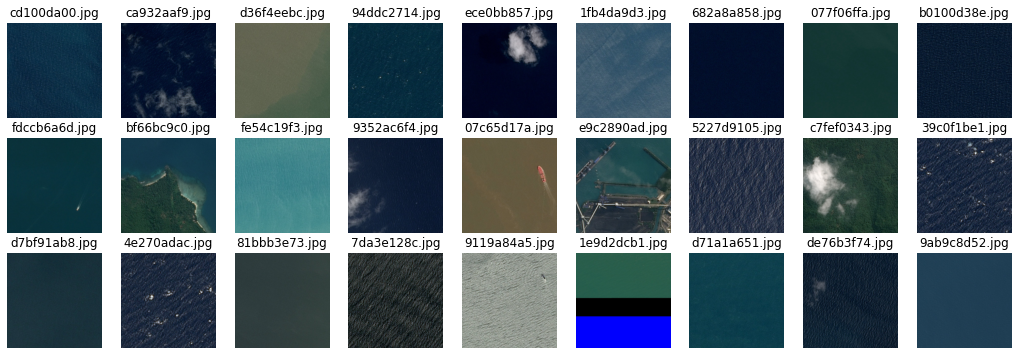

In [7]:
# Plot some images from the train set 
w = 9
h = 3

# we resize the format of the images with a 200x200 shape
# this function uses the open, resize and array functions to manage data visualizations
load_img = lambda filename: np.array(PIL.Image.open(f"../train_v2/{filename}").resize((200, 200)))

_, axes_list = plt.subplots(h, w, figsize=(2*w, 2*h)) # define a grid of (w, h)

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        img = np.random.choice(train) # take a random train filename
        ax.imshow(load_img(img)) # load and show
        ax.set_title(img)
        

### Run-length encoding 

The encoded string looks like this: start, length, start, length, ... , where each pair of (start, length) draws a line of length pixeles starting from position start. The start position, in turn, is not a (x, y) coordinate but an index of the 1-d array resulting of flattening the 2-d image into a rows-after-row 1-d sequence of pixels. Knowing the shape of the images we can just unfold this 1-d representating into a 2-dimensions mask using // and %.

We load this .cvs file and write some useful functions to better use the econding.

In [8]:
df = pd.read_csv("../train_ship_segmentations_v2.csv", index_col=0).dropna()
display(df.head())

print('Example of a encoding run-lenght format: \n')
df['EncodedPixels']['000155de5.jpg']

,EncodedPixels
ImageId,
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...


Example of a encoding run-lenght format: 



'264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33 339922 33 340690 33

<a id="subsection-one-"></a>

## Statistics about data

In [10]:
# Read CSV as dataframe
df_count = pd.read_csv(os.path.join('../train_ship_segmentations_v2.csv'))
print('Total number of images (original): %d' % df_count['ImageId'].value_counts().shape[0])

# Create a dataframe with unique images id as indexes and number of ships and image sizes as new columns
df_count = df_count[~df_count['ImageId'].isin(['6384c3e78.jpg'])] # remove corrupted file 
unique_img_ids = df_count.groupby('ImageId').size().reset_index(name='counts')
print('Total number of images (after removing corrupted images): %d' % df_count['ImageId'].value_counts().shape[0])

Total number of images (original): 192556
Total number of images (after removing corrupted images): 192555


<AxesSubplot:xlabel='counts', ylabel='Count'>

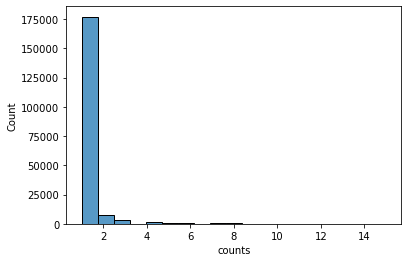

In [21]:
sns.histplot(data=unique_img_ids['counts'])

In [24]:
# ImageId가 겹치는 이미지들의 숫자==각 이미지에 몇개의 배가 존재하는가?(nan값이 포함되어있다.)
for i in list(set(unique_img_ids['counts'])):
    print('Number of {} : {}'.format(i,len(unique_img_ids[unique_img_ids['counts']==i])))

Number of 1 : 177103
Number of 2 : 7674
Number of 3 : 2954
Number of 4 : 1622
Number of 5 : 925
Number of 6 : 657
Number of 7 : 406
Number of 8 : 318
Number of 9 : 243
Number of 10 : 168
Number of 11 : 144
Number of 12 : 124
Number of 13 : 75
Number of 14 : 76
Number of 15 : 66


Number of images with ships :     42556 
Number of images without ships : 149999
  
Proportion: 0.3
 
Ration with ships:     0.22
Ration without ships:  0.78


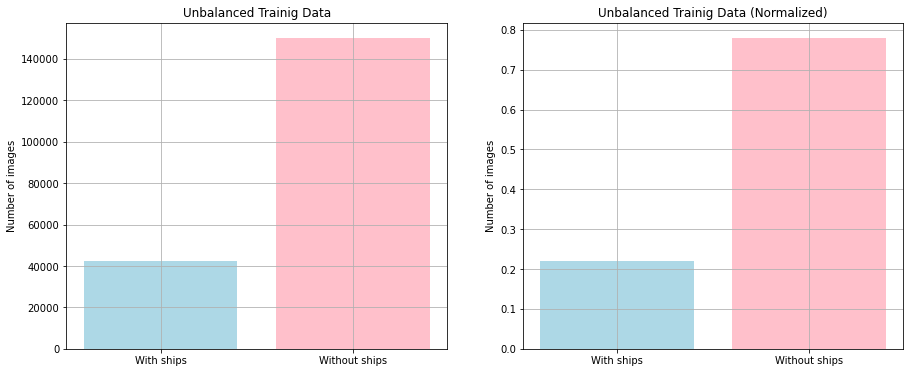

In [25]:
# Count number of ships per image
df_wships = df_count.dropna()  
df_wships = df_wships.groupby('ImageId').size().reset_index(name='counts')
df_woships = df_count[df_count['EncodedPixels'].isna()] # EncodedPixels가 nan인 데이터들을 추출

# 배가 없는 이미지들의 비율
print('Number of images with ships :     %d \nNumber of images without ships : %d\n  \nProportion: %0.1f\n ' \
      % (df_wships.shape[0], df_woships.shape[0], df_wships.shape[0] / df_woships.shape[0]))


print('Ration with ships:     ' +str(round((df_wships.shape[0]/len(train)),2)))
print('Ration without ships:  ' +str(round((df_woships.shape[0]/len(train)),2)))

#make plots

plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.bar(['With ships','Without ships'], [len(df_wships),len(df_woships)], color = ['lightblue','pink'])
plt.ylabel('Number of images')
plt.title('Unbalanced Trainig Data')
plt.grid()

plt.subplot(1,2,2)
plt.bar(['With ships','Without ships'], [len(df_wships)/len(train),len(df_woships)/len(train)], 
        color = ['lightblue','pink'])
plt.ylabel('Number of images')
plt.title('Unbalanced Trainig Data (Normalized)')
plt.grid()

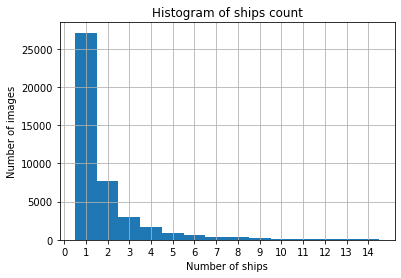

In [9]:
# Plot histogram
hist = df_wships.hist(bins=np.arange(df_wships['counts'].max())+0.5)
plt.xticks(range(15))
plt.title("Histogram of ships count")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show(hist)

In [30]:
from tabulate import tabulate

counts = df_wships['counts'].value_counts(sort=False)
results = [(i, counts[i]) for i in range(1,16)]
print(tabulate(results, headers=['number of ships','number of images'], tablefmt='presto'))

   number of ships |   number of images
-------------------+--------------------
                 1 |              27104
                 2 |               7674
                 3 |               2954
                 4 |               1622
                 5 |                925
                 6 |                657
                 7 |                406
                 8 |                318
                 9 |                243
                10 |                168
                11 |                144
                12 |                124
                13 |                 75
                14 |                 76
                15 |                 66


The Challenge of detecting the ships in the images can be thought as a classification problem for pixels, where, for each image, we need to classify 768 × 768 pixels in one of two classes: ship and no-ship. At pixel level the problem of imbalance data is more accentuated than the case of considering the whole image. To find the proportion between ship and no-ship at pixel level we need to consider the total number of pixel and the pixel where the ships are. The total number of pixel is 768×768×n_imgs while the number of 'ship pixels' is the sum of the all the pair positions of the  strings encoded in 'EncodedPixels'. Finally the total amount of 'no ship pixels' is just: total pixels - 'ship pixels'. We tried to do that but, while counting the numbers of ship pixels, we exceeded the ammount of memory provide by Kaggle. Therefore we decided to report the results of other notebooks and discuss the results.


In [31]:
def show_pixels_distribution(df):
    """
    Prints the amount of ship and no-ship pixels in the df
    """
    # Total images in the df
    n_images = df['ImageId'].nunique() 
    
    # Total pixels in the df
    total_pixels = n_images * 768 * 768 

    # Keep only rows with RLE boxes, transform them into list of pixels, sum the lengths of those lists
    ship_pixels = df['EncodedPixels'].dropna().apply(rle_to_pixels).str.len().sum() 

    ratio = ship_pixels / total_pixels
    print(f"Ship: {round(ratio, 3)} ({ship_pixels})")
    print(f"No ship: {round(1 - ratio, 3)} ({total_pixels - ship_pixels})")
    

In [106]:
df = pd.read_csv("../train_ship_segmentations_v2.csv")
show_pixels_distribution(df)


Ship: 0.001 (128092863)
No ship: 0.999 (113446057281)


**Results** (considering the whole dataset):

Ship:    0.001 (127777104) 

No ship: 0.999 (113446373040)

As we can see from the results,  only 1‰ of the pixels are *ships*, while 99.9% of the pixels are *no-ships*. This imply that the dataset is very unbalanced at pixel level. Below we have reported the results considering only the images with the ships, to understand if the problem persists.

In [33]:
show_pixels_distribution(df.dropna())

Ship: 0.005 (128092863)
No ship: 0.995 (24972457281)


**Results** (considering only the images with ships):


Ship: 0.005 (127777104)


No ship: 0.995 (24972773040)

The class imbalance is reduced, but it is still very high: 5‰. So in the images with ships only 0.5% of the pixels are ships while 99.5% are no-ships. This condition of extreme class imbalance of the dataset is a problem and so we had to take this into account when deciding which strategy was best for solving the ship detection task.

## Images Visualizations
<a id="subsection-two-2"></a>

In this section we will investigate better the dataset, in particular the images and the masks that will be used in the training part. 
Firstly we plot only the maks, while in after we merge the images with the mask obtaining the real satellite image with the presenceof the ship detected. 

In [105]:
temp = np.random.choice(df['EncodedPixels'])
display(type(temp))
display(temp)

str

'ImageId EncodedPixels'

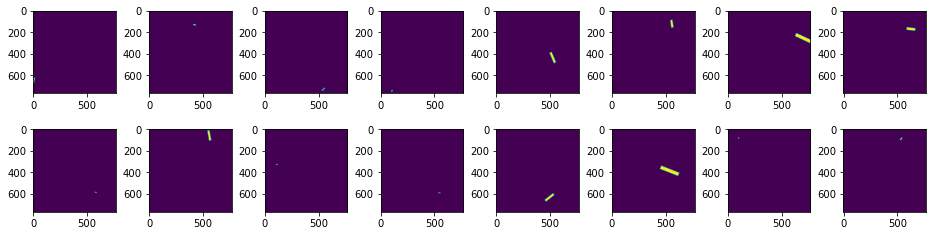

In [62]:
# Plot some masks
w = 8
h = 2

_, axes_list = plt.subplots(h, w, figsize=(2*w, 2*h))
plt.subplots_adjust(wspace=0.4)
ax.set(xlim=(0, 768), ylim=(0, 768))
for axes in axes_list:
    for ax in axes:
        ax.axis('auto')
        canvas = np.zeros((768, 768))
        pixels = rle_to_pixels(np.random.choice(df.dropna()['EncodedPixels'])) # nan인 데이터는 float type이어서 rle_to_pixels함수에서 split 진행할 수 없음.
        canvas[tuple(zip(*pixels))] = 1
        ax.imshow(canvas);

In [116]:
df.groupby("ImageId")[['EncodedPixels']].to_frame()

AttributeError: 'DataFrameGroupBy' object has no attribute 'to_frame'

In [117]:
len(df)

231723

In [159]:
#In some images there are more that one ship so the df has more than one row, we merge this data into one rle code
temp_df = df.dropna().groupby("ImageId")[['EncodedPixels']].agg(lambda rle_codes: ' '.join(rle_codes)).reset_index()
load_img = lambda filename: np.array(PIL.Image.open(f"../train_v2/{filename}"))

In [160]:
temp_df.loc[np.random.randint(len(temp_df)),'EncodedPixels']
# df['EncodedPixels'].unique()

'152348 3 153116 6 153884 6 154651 7 155419 6 156187 6 156955 6 157723 6 158491 6 159258 6 160026 6 160794 6 292872 2 293640 4 294407 7 295175 7 295943 7 296711 6 297478 7 298246 7 299014 7 299781 8 300549 7 301317 7 302085 7 302852 8 303620 7 304390 5 305161 2 243016 3 243782 5 244550 6 245319 5 246087 5 246855 6 247624 5 248392 5 249160 6 249928 6 250697 5 251465 6 252233 6 253002 3 253770 1 273844 2 274612 4 275379 7 276147 9 276914 12 277682 14 278451 15 279221 14 279991 11 280761 9 281531 6 282301 4 283071 1'

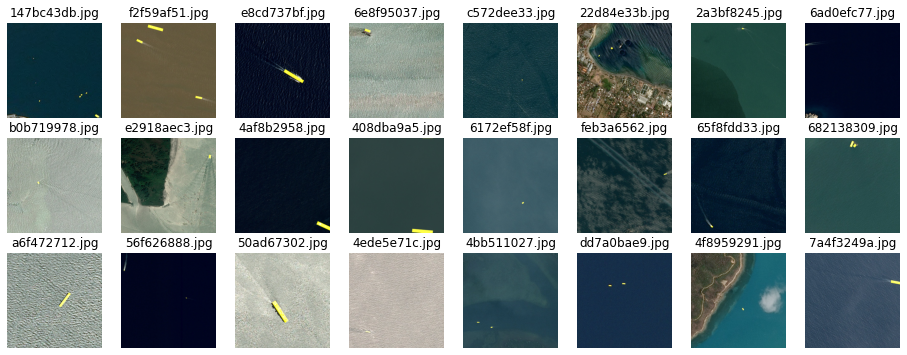

In [162]:
# Plot some images with maks
w = 8
h = 3

_, axes_list = plt.subplots(h, w, figsize=(2*w, 2*h))

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        row_index = np.random.randint(len(temp_df)) # take a random row from the df
        ax.imshow(apply_mask(load_img(temp_df.loc[row_index, 'ImageId']), rle_to_pixels(temp_df.loc[row_index, 'EncodedPixels'])))
        # print(load_img(df.loc[row_index, 'ImageId'])[123,123,[0,1,2]])
        ax.set_title(temp_df.loc[row_index, 'ImageId'])

## Data Sampling
<a id="subsection-three-2"></a>

It is possible to notive the unblancing of the dataset regarding the presence or not pf ships in the images. In particular in the trainig set we have arounf 22% of the images with ships while the others 78% without. As we will se later we want to select only the images with ships to manage the detection task, so it is a good idea to classify before the images according to the presence of ships and then proceeed with the detection. 

To have a better performance in the classification it could be better to manipulate a little bit the images in such a way to have a better differentiation among the images and a better balancing between the high and low presence classes. In this section we will explore this kind of arguments.

**Create different datasets**

One way to proceed can be to make the dataset used for the trainig in the classification task more balanced, in this case we can use all the images with ships and balance the dataset with part of the non-ship images. We will create two different dataset as follow:

* 50% Ship + 50% No Ship ---> Total of 85.112 Images
* 100% Ship + 0% No Ship ---> Total of 42.556  Images

We will train the classifier and test the performace for different trainig sets. 

Recall that each image corresponds to a number of masks equal to the number of ships contained in the image.

In [163]:
masks = pd.read_csv(os.path.join('../train_ship_segmentations_v2.csv'))
masks = masks[~masks['ImageId'].isin(['6384c3e78.jpg'])] # remove corrupted file 

print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0], 'unique images found')

231722 masks found
192555 unique images found


To obtain the first dataset (50% Ship + 50% No Ship) we need to undersample the empty images. The number of images with ships are 42.556 so we need to remove 107443 (=149999 - 42.556) images from the no ship class.

In [164]:
# To an empty image correspond just one mask
# 배가 없는 사진과 배가 있는 사진의 비율을 맞춰주기 위해서 배가 있는 사진만큼만 배가 없는 사진의 수를 남겨두고 나머지 모두 지움.
n_rem = 107443 # = 149999 - 42.556
masks = masks.drop(masks[masks.EncodedPixels.isnull()].sample(n_rem,random_state=42).index)

In [166]:
masks.shape[0] # ImageId가 중복되어 있어서 그런것 같다. 중복이 아니라면 85112가 나와야함

124279

In [168]:
masks['ImageId'].value_counts().shape[0] # 중복을 제거하면 원래 의도했던대로 나온다.

85112

**Split into training and validation groups**

We stratify by the number of boats appearing so we keep the proportion of occurrences before the split.

In [178]:
from sklearn.model_selection import train_test_split

unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.05, 
                 stratify = unique_img_ids['counts'],
                 random_state=42
                ) # counts를 이용하여 원래의 데이터 셋에서의 각 class들의 비율을 맞추어서 dataset을 나눈다.
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)

In [187]:
# str type이라는 것은 배의 좌표가 있는 데이터이므로 counts값 그대로를
# str type이 아니라는 것은 NaN값이므로 0을 대입
train_df['counts'] = train_df.apply(lambda c_row: c_row['counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0,1) # 왜 1이 들어가지...?
valid_df['counts'] = valid_df.apply(lambda c_row: c_row['counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0, 1)

In [188]:
print(train_df.ImageId.nunique(), 'unique images in train set')
print(valid_df.ImageId.nunique(),' unique images in test set')


80856 unique images in train set
4256  unique images in test set


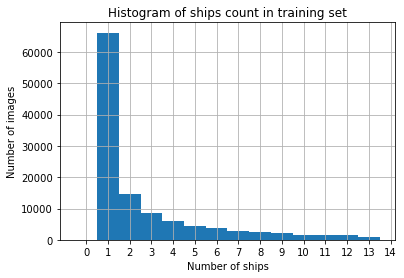

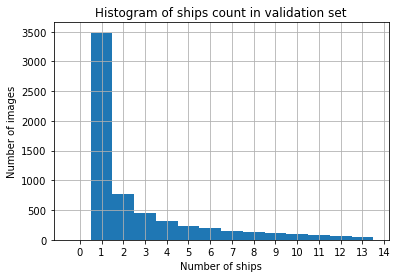

In [179]:
# Plot histogram

hist = train_df.hist(bins=np.arange(train_df['counts'].max())-0.5)
plt.xticks(range(15))
plt.title("Histogram of ships count in training set")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show(hist)


hist = valid_df.hist(bins=np.arange(valid_df['counts'].max())-0.5)
plt.xticks(range(15))
plt.title("Histogram of ships count in validation set")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show(hist)

In [189]:
#save the dataset into .csv files
train_df.to_csv('train_df.csv',index=False)
valid_df.to_csv('valid_df.csv',index=False)

To obtain the second dataset (100% Ship + 0% No Ship) we need to remove all the images without ships from the original dataset.

In [190]:
masks = pd.read_csv(os.path.join('../train_ship_segmentations_v2.csv'))
masks = masks[~masks['ImageId'].isin(['6384c3e78.jpg'])] # remove corrupted file 
masks_ship = masks.drop(masks[masks.EncodedPixels.isnull()].index) # remove all the images without ships


**Split into training and validation groups**


In [191]:
from sklearn.model_selection import train_test_split
unique_img_ids = masks_ship.groupby('ImageId').size().reset_index(name='counts')
train_ids_ship, valid_ids_ship = train_test_split(unique_img_ids, 
                 test_size = 0.05, 
                 stratify = unique_img_ids['counts'],
                 random_state=42
                )
train_df_ship = pd.merge(masks_ship, train_ids_ship)
valid_df_ship = pd.merge(masks_ship, valid_ids_ship)

In [192]:
train_df_ship['counts'] = train_df_ship.apply(lambda c_row: c_row['counts'] if 
                                            isinstance(c_row['EncodedPixels'], str) else
                                            0, 1)
valid_df_ship['counts'] = valid_df_ship.apply(lambda c_row: c_row['counts'] if
                                            isinstance(c_row['EncodedPixels'], str) else
                                            0, 1)

In [193]:
print(train_df_ship.ImageId.nunique(), 'unique images in train set')
print(valid_df_ship.ImageId.nunique(),' unique images in test set')


40428 unique images in train set
2128  unique images in test set


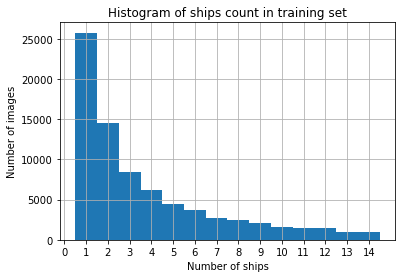

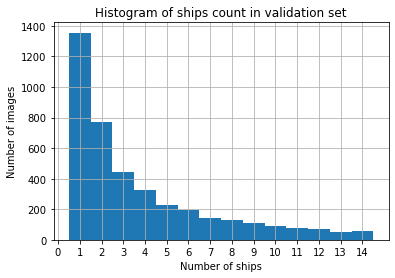

In [194]:
# Plot histogram

hist = train_df_ship.hist(bins=np.arange(train_df_ship['counts'].max())+0.5)
plt.xticks(range(15))
plt.title("Histogram of ships count in training set")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show(hist)


hist = valid_df_ship.hist(bins=np.arange(valid_df_ship['counts'].max())+0.5)
plt.xticks(range(15))
plt.title("Histogram of ships count in validation set")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show(hist)

In [29]:
#save the dataset into .csv files
train_df_ship.to_csv('train_df_ship.csv',index=False)
valid_df_ship.to_csv('valid_df_ship.csv',index=False)

We will continue the challange in another notebook to have a better reading and organization. In this first notebook we faced the problem and analyze the data avalibale. In particulat we detected an high unbalanced classification problem (pixel level). We shown the masks and the images and the distributions of images with and without ships. In the next notebooks we will explore the classification of images into two classes, one with ship and another without ships. 